#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 5 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [29]:
import sys
!{sys.executable} -m pip install gdown h5py

In [30]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=2f7ed34d-7984-4b16-8483-3a7919ada081
To: /Users/emmaboehly/Documents/Master2/Brain like computation and intelligence/NX414_Predicting_neural_activity/IT_data.h5
100%|██████████| 384M/384M [00:19<00:00, 19.4MB/s] 


'IT_data.h5'

### Load the data

In [31]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [32]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


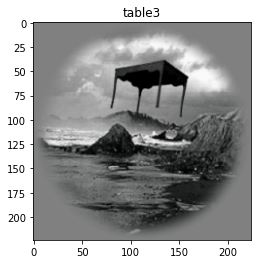

In [33]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

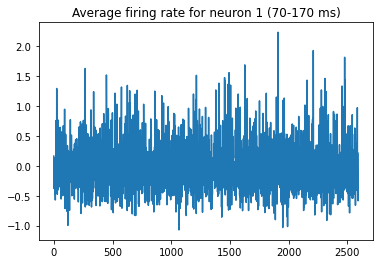

In [34]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])
plt.show()

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [35]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# Processing of the dataset

In [36]:
#flatten the images and their channels
flat_train = stimulus_train.reshape(stimulus_train.shape[0],-1)
flat_val = stimulus_val.reshape(stimulus_val.shape[0],-1)

# Standardize the data
var_iszero = flat_train.var(axis = 0) > 1e-4 # remove constant features
flat_train = flat_train[:, var_iszero] 
flat_val = flat_val[:, var_iszero]
scaler = StandardScaler()
flat_train = scaler.fit_transform(flat_train)
flat_val = scaler.transform(flat_val)


# Model fitting

In [37]:
linear_model = LinearRegression()
linear_model.fit(flat_train, spikes_train)

LinearRegression()

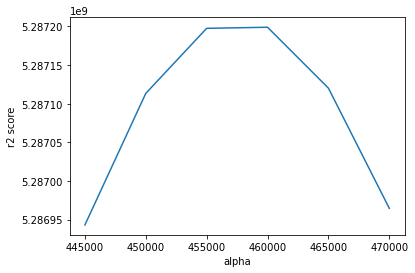

In [38]:
alphas = [445000, 450000, 455000, 460000, 465000, 470000]
ridge_model, best_alpha = RidgeCV(flat_train, spikes_train, alphas)

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

In [39]:
def compute_scores(model, dataset, true_prediction) : 
    """compute the r2 correlation coefficient and explained variance for each neuron individually

    Args:
        model : ML model we want to evaluate
        dataset (ndarray): input data of the processed image's pixels. Used to compute the prediction
        true_prediction (_type_): actual neural activity of the neuron

    Returns:
        tuple : r2 correlation coefficient and explained variance arrays for each neuron
    """
    predict = model.predict(dataset)
    r2 = r2_score(true_prediction, predict, multioutput = 'raw_values')
    var = explained_variance_score(true_prediction, predict, multioutput = 'raw_values')
    return r2, var


def scores_plot(r2, var) : 
    """plot the r2 correlation coefficient and explained variance for each neuron individually

    Args:
        r2 (array): r2 coefficient computed for a given model
        var (array): explained variance computed for a given model

    Returns:
        tuple ([n0, n1, ...], bins, [patches0, patches1, ...]): scatter plot of the scores
    """
    p = plt.figure(figsize=(12,7))
    plt.scatter(np.arange(len(r2)), r2, label = 'r2 score')
    plt.scatter(np.arange(len(var)), var, label = 'explained variance')
    plt.xlabel('IT neurons')
    plt.ylabel('score')
    plt.legend()
    return p

def distribution_plot(var) :
    """histogram of the distribution of the explained variance across neurons

    Args:
        var (array of double): explained variance computed for each neuron for the model

    Returns:
        tuple ([n0, n1, ...], bins, [patches0, patches1, ...]): histogram of the distribution
    """
    p = plt.figure(figsize=(12,7))
    plt.hist(var, bins=20)
    plt.xlabel('explained variance')
    plt.ylabel('count')
    return p

def evaluate_prediction_plot(model, dataset, true_prediction, model_title=None) :
    """compute and plot the r2 coefficient and explained variance for each neuron and the distribution of the explained variance

    Args:
        model : ML model we want to evaluate
        dataset (ndarray): input data of the processed image's pixels. Used to compute the prediction
        true_prediction (array): actual neural activity of the neuron 
        model_title (string, optional): description of the model used, to add at the end of the title of the graphs. Defaults to None.
    """
    
    r2, var = compute_scores(model, dataset, true_prediction)
    
    scatter_plot = scores_plot(r2, var)
    if model_title is None:
        scatter_plot.suptitle('R2 score and explained variance on the validation set for each IT neurons')
    else:
        scatter_plot.suptitle('R2 score and explained variance on the validation set for each IT neurons when fitting a {}'.format(model_title))
    
    dist_plot = distribution_plot(var)
    if model_title is None:
        dist_plot.suptitle('Histogram of the explained variance across neurons')
    else :
        dist_plot.suptitle('Histogram of the explained variance across neurons when fitting a {}'.format(model_title))
        
    plt.show()
    
    p = plt.figure(figsize=(10,6))
    plt.boxplot(var, vert=False)
    


## Plot of the results

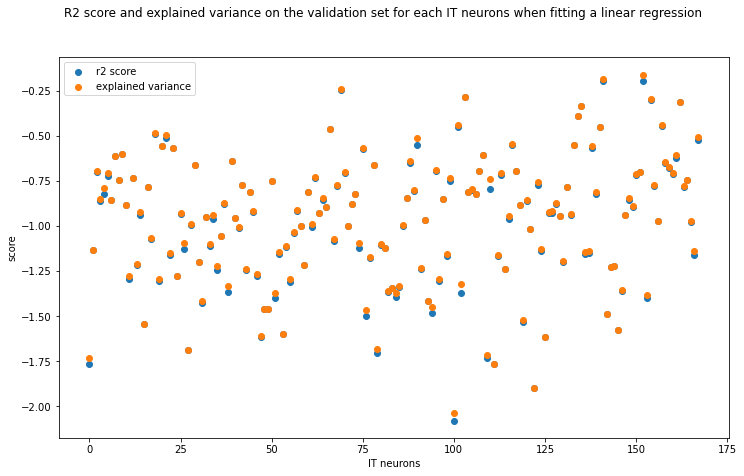

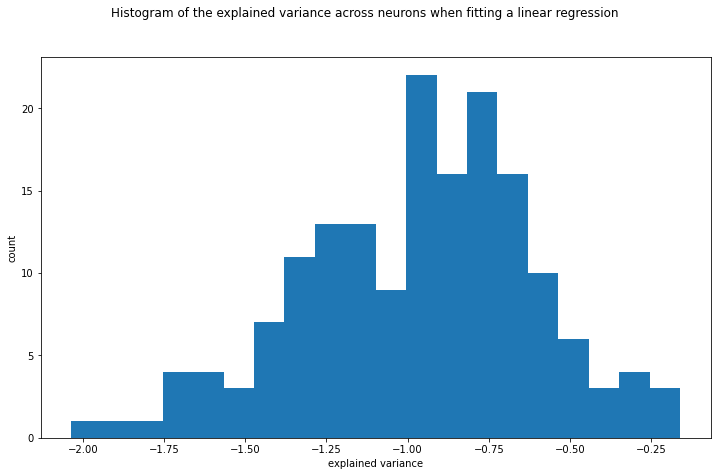

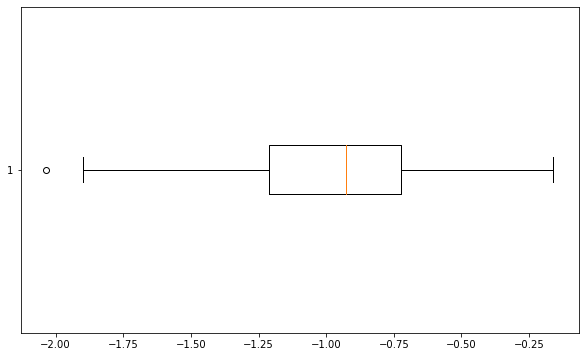

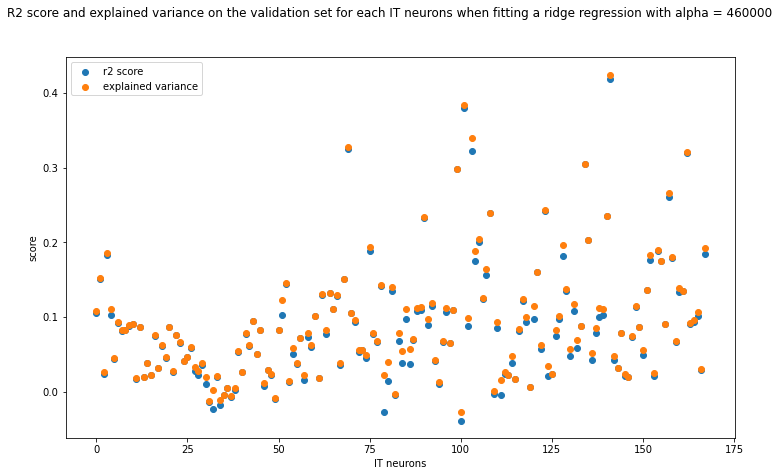

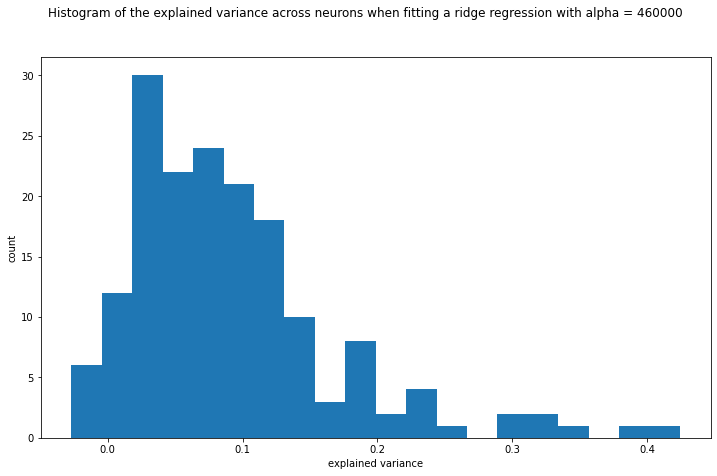

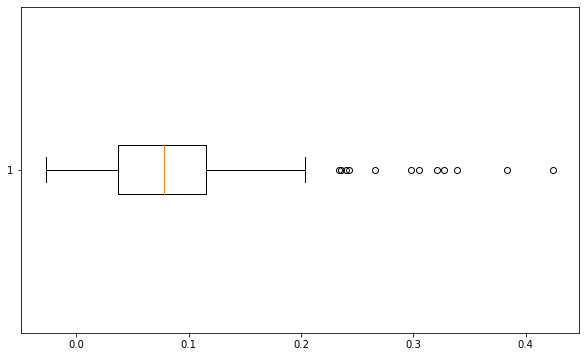

In [40]:
evaluate_prediction_plot(linear_model, flat_val, spikes_val, model_title='linear regression')
evaluate_prediction_plot(ridge_model, flat_val, spikes_val, model_title='ridge regression with alpha = {}'.format(best_alpha))
plt.show()

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

# PCA

In [41]:
# PCA on the training set to reduce the dimensionality of the data to 1000
pca = PCA(n_components=1000)
flat_pca_train = pca.fit_transform(flat_train)
flat_pca_val = pca.transform(flat_val)

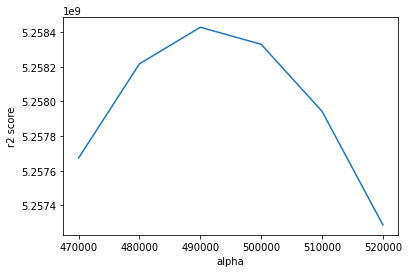

In [45]:
# apply ridge regression on the PCA data
alphas = [470000, 480000, 490000, 500000, 510000, 520000]
ridge_pca_model, best_alpha_pca = RidgeCV(flat_pca_train, spikes_train, alphas)

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

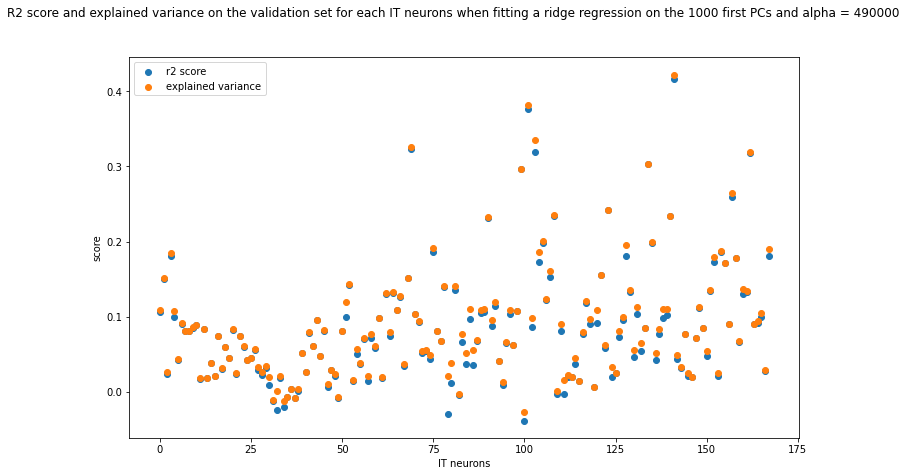

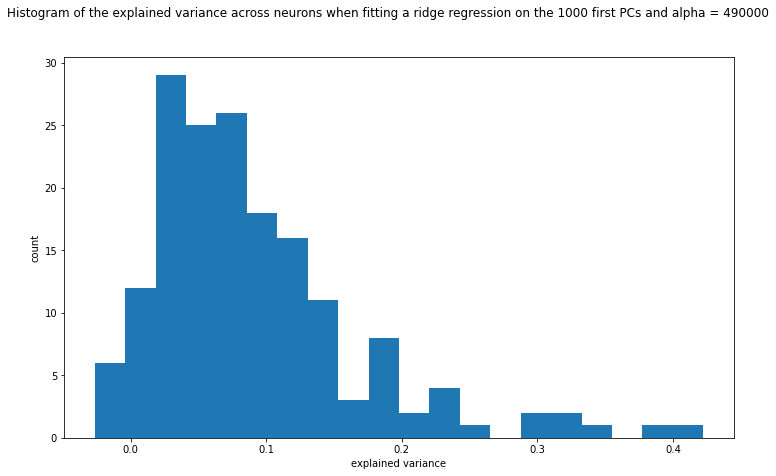

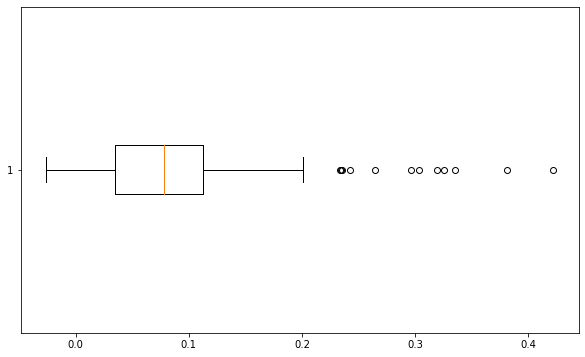

In [46]:
evaluate_prediction_plot(ridge_pca_model, flat_pca_val, spikes_val, model_title='ridge regression on the 1000 first PCs and alpha = {}'.format(best_alpha_pca))

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?